## DHI Consortium Database - Machine Learning Support Vector Machine
### Kevin Jaggs Jan 2020

### Objective:
Fit a linear SVM (Support Vector Machine) algorithm to the SAAM database. Tune the hyper parameters to give the best possible result without overfitting the data. 

### Method:

* Step 1 -  [Import the required python modules](#section_id_import_modules). Import of pandas dataframe, numpy, matplotlib and sklearn modules


* Step 2 -  [User selected parameters](#section_id_parameters). Options for user to select scoring criteria, cross validation number etc.


* Step 3 -  [Import SAAM_Database_csv_to_pandas](#section_id_import_saam_database). Import of dhi consortium database csv file to pandas dataframe. Note: the csv file is an independently formatted file, composed of pg, dhi index adj and user-scored parameters. This format is created in a separate python module.


* Step 4 -  [Split dataset into test and train portions](#section_id_test_train_split). For conventional machine learning workflows, the input and output datasets are divided into training and testing sub-volumes. Algorithms are trained on the (not suprisingly) 'train' dataset and model outcomes are compared using the 'test' dataset, to prevent over-fitting.


* Step 5 -  [Feature scale input data](#section_id_feature_scale). Rescale the features/input columns such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one.


* Step 6 -  [Fit default svm](#section_id_svm_raw). Fit a simple Linear Kernel SVM model using X_train_scaled. This output will provide a benchmark for any improvements noted in hyperparameter selection or feature selection.


* Step 7 - [Hyperparameter tuning with GridsearchCV](#section_id_gridsearch) Identify the best SVM model fit parameters using GridsearchCV


* Step 8 - [Feature section using recursive feature elimination](#section_id_rfe) Optimal number, and identity, of features is selected to give the best possible score as chosen by the user in section 2.


* Step 9 - [Filter training dataset to recursive feature elimination output](#section_id_filter_features) Scaled training data is filtered down to only the optimal features, selected in step 8.


* Step 10 - [Filter training dataset to optimal number of features](#section_id_final_model) Fit the final gridsearchcv output model training dataset filtered to the optimal number of features.


* Step 11 - [Calculate Chi2 statistic](#section_id_chi2_calc) Compare the outputs from all stages of the model evaluation: raw, gridsearchcv and rfecv.


* Step 12 - [Chi2 statistically significant features](#section_id_chi2_list) Print the data features with a score >= critical value.


* Step 13 - [Fit SVM model to Chi2 selected features dataset](#section_id_chi2_fit) Model parameters are the outputs of GridsearchCV.


* Step 14 - [Final model comparisons](#section_id_model_comparisons) Compare the outputs from all stages of the model evaluation: raw, GridsearchCV, RFEcv and Chi2.


* Step 15 - [ROC curve comparison](#section_id_roc_curve) Comparison of the ROC curves for raw. GridsearchCV, RFEcv and Chi2 result models. Labels show the AUC score.


* Step 16 - [Precision Recall curve comparison](#section_id_pr_curve) Compare the precision recall curves for the raw, gridsearchcv and rfe models. Labels show the AUPR score.

### Dataset
The SAAM database is a record of over 340 (as of Jan 2021) O&G exploration prospects, each one displaying a DHI signature. This database is part of the DHI consortium, an industry-funded project headed by Rose & Associates  with the objective of creating a methodical, repeatable and technically robust workflow for risk assessment of DHI prospects.  

Each prospect is evaluated by scoring over 40 questions related to the DHI characteristics, data quality, potential pitfalls and modelling results.

This is a binary classification exercise as the final ouput of the dataset is denoted by 0 for failure cases, and 1 for success cases. 

Options to include Pg and Adj DhiIndex in the evaluations, but this should be regarded as data leakage, partivularly in the case of DHI index Adj. Inclusion of Pg and/or DHI Index Adj will result in overfitting, so proceed with caution.

### Programming
This evaluation is performed using Python code and SKlearn provides the SVM classifier modules. 

### Outputs
* Fitted SVM models for default parameters (raw), GridsearchCV hyperparameter tuning, Recursive Feature Elimination and Chi2 features.
* Confusion matrix for Raw, GridsearchCV, RFE & Chi2 models.
* Accuracy, Precision, F1 or AUC scoring metric comparison for Raw, GridsearchCV, RFE & Chi2 models.
* ROC_AUC plot for Raw, GridsearchCV, RFE & Chi2 models.
* AU_PR plot for Raw, GridsearchCV, RFE & Chi2 models.

<a id='section_id_import_modules'></a>

### 1. Import required Python Modules

In [17]:
print(__doc__)

#pandas dataframe - similar to a python version of excel. Most efficient way to perform data operations
import pandas as pd

#numpy for most mathematical operations
import numpy as np

#matplotlib for plotting functions
#import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
#seaborn for plotting heatmap
#import seaborn as sns

#sklearn for machine learning modules and scoring algorithms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix,classification_report

#recursice festure elimination
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold

#chi2 calculation
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import scipy

#plotting
import matplotlib.pyplot as plt


Accuracy - ratio of correctly predicted observation to the total observations. 
Accuracy works best if false positives and false negatives have similar cost. 
Accuracy = TP+TN/TP+FP+FN+TN

Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.
High precision relates to the low false positive rate.
Precision = TP/TP+FP

Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class
Recall = TP/TP+FN

F1 score - F1 Score is the weighted average of Precision and Recall. Takes both false pos and false neg into account. 
Use F1 if you have an uneven class distribution. 
If the cost of false positives and false negatives are very different - look at both Precision and Recall.
F1 Score = 2*(Recall * Precision) / (Recall + Precision)

roc_auc - the area under the receiver operating characteristic, plots the False Positive rate vs True Positive Rate for differ

<a id='section_id_parameter'></a>

### 2. User selected parameters
Select scoring method, options of 'accuracy', 'precision', 'f1', 'roc_auc'
Crossvalidation fold i.e how many subsets the training data is split into for cross validation purposes, recommend value above 3 as this below this point overfits the data and will create a prediction error in the final assessment.


In [18]:
'''
Accuracy - ratio of correctly predicted observation to the total observations. 
Accuracy works best if false positives and false negatives have similar cost. 
Accuracy = TP+TN/TP+FP+FN+TN

Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.
High precision relates to the low false positive rate.
Precision = TP/TP+FP

Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class
Recall = TP/TP+FN

F1 score - F1 Score is the weighted average of Precision and Recall. Takes both false pos and false neg into account. 
Use F1 if you have an uneven class distribution. 
If the cost of false positives and false negatives are very different - look at both Precision and Recall.
F1 Score = 2*(Recall * Precision) / (Recall + Precision)

roc_auc - the area under the receiver operating characteristic, plots the False Positive rate vs True Positive Rate for different thrshold cut offs.
The best models should plot towards the upper left quadrant of the plot, therefore calculating the area under the curve is a good measure of model performance.
'''

#score_cat = 'roc_auc'
score_cat = 'accuracy'
#score_cat = 'precision'
#score_cat = 'f1_score'

#plot labels are updated based upon 
if score_cat == 'roc_auc':
    plot_label = 'AUC'
if score_cat == 'accuracy':
    plot_label = 'Accuracy'
if score_cat == 'precision':
    plot_label = 'Precision' 
if score_cat == 'recall':
    plot_label = 'Recall'    
if score_cat == 'f1_score':
    plot_label = 'f1 score'  
    
#number of folds (equal data subsets) employed in cross validation - recommended to use above 4 for this dataset    
cross_validation_fold = 5    

#confidnce interval for chi2 calculation
conf_int = 0.95

#see random number generators - for repeatability
random_seed = 57


<a id='section_id_import_saam_database'></a>

### 3. Import SAAM Database csv file to pandas
The csv file is imported into a pandas dataframe, allowing ease of computation in later modules. All columns are considered numeric. The column header is the data category and the index is the prospect name. All undrilled prospects have been removed from the database

In [19]:
def readcsvfile():
    '''
    (csv)->(pandas dataframe)
    routine to read import csv file to pandas
    comma separation, column headers = first row of text
    All column data is considered numeric
    Index = prospect name/ID
    -999.25 values are converted to numpy NaN
    PRECONDITION: Import csv file is the correct format. All prospects without a 1/0 output removed.
    KJAGGS June 2020
    '''
    
    #read csv file to pandas dataframe
    df = pd.read_csv('saam_v26b_cat.csv', encoding = 'utf-8',header=0,sep=',')
    df = df.set_index('Prospect/ zone: ')
    df = df.apply(pd.to_numeric, errors='ignore')
    df = df.replace(-999.25,np.NaN)
    df = df.replace(np.NaN,0)
    #print(df.isnull().any())
    return df

df_saam = readcsvfile()

###optional qc features - remove hash/# to view 
#print(df_saam.head)
#print(df_saam.columns.tolist)

print("Dataframe size on import")
print("Number of prospects :", df_saam.shape[0])
print("Number of data categories :", df_saam.shape[1])

print("\nProportion (%) of Success:Fail outcomes")
print("1 = Success")
print("0 = Fail")
print(df_saam['Success or Fail'].value_counts(normalize=True) * 100)

Dataframe size on import
Number of prospects : 352
Number of data categories : 43

Proportion (%) of Success:Fail outcomes
1 = Success
0 = Fail
1    53.125
0    46.875
Name: Success or Fail, dtype: float64


<a id='section_id_test_train_split'></a>

### 4. Split into test and train datasets
Data is divided into test and training sub-volumes for the purpose of fitting models and preventing over-fitting/bias issues. The current defaults in the module below are to split 80:20 train:test. No random number seeding, no shuffling of input data and no stratifying (equal proportions of success/fail  outcomes in each sub-volume). These faetures are adjusted at the bottom of the next cell as the input to function; user can change accordingly.

In [20]:
def training_split(Xdata, Ydata, test_size=0.2,stratify=None,random_state=None,shuffle=False):
    '''
    (DataframeXColumns)(DataframeYColumn)=>(array)(array)(array)(array)
    For the purposes of splitting x and y data into test and training sets
    train_test_split is currently set to default settings
    PRECONDITION: Input datasets are formatted correctly
    KJAGGS June2020
    '''

    #split the data - default settings for now
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=test_size,stratify=stratify, random_state = random_state, shuffle = shuffle)

    #resize the output data sets if a 1 column vector, now compatible  with regression modules
    if len(X_train.shape) <2:  
       X_train = X_train.ravel()
    if len(y_train.shape) <2:  
       y_train = y_train.ravel()
    if len(X_test.shape) <2:  
       X_test = X_test.ravel()
    if len(y_train.shape) <2:  
       y_test = y_test.ravel()
    
    return X_train, X_test, y_train, y_test

#output dataset is success/fail only
y = df_saam['Success or Fail']

X = df_saam

#remove result column from input dataset
#option to keep pg and dhi index adjusted in training dataset just change the # between the two lines below to make the change

#X.drop(['Success or Fail'], axis=1, inplace=True)
#X.drop(['Success or Fail','DHI Index after data adjustment','Pg'], axis=1, inplace=True)
X.drop(['Success or Fail','DHI Index after data adjustment'], axis=1, inplace=True)
#X = df_saam[['DHI Index after data adjustment','Pg']]
#X = df_saam[['DHI Index after data adjustment']]

#Extract the column header labels from numpy array. Used for plotting labels and recursive feature elimination later on.
col_vals = X.columns.values.reshape(-1,1)
#print(col_vals)

#split the datasets
#Shuffle = randomly shuffle the data before, If shuffle=False then stratify must be None.
#random state = seeding of random numbers for reproducibility across various modules
#stratify = ensure proportion of outcomes are the same across both datasets i.e % of successes in train = % of successes in test
X_train, X_test, y_train, y_test = training_split(X,y,shuffle=True,random_state=random_seed,stratify=y,test_size=0.3)

print("Train and test dataset sizes")
print("Training dataset size :", X_train.shape)
print("Test dataset size :", X_test.shape)




Train and test dataset sizes
Training dataset size : (246, 41)
Test dataset size : (106, 41)


<a id='section_id_feature_scale'></a>

### 5. Feature scale the input data
Input independent variables are scaled so that the the attribute mean is zero with a unit standard deviation. Gradient descent algorithms (neural networks, for example) run more efficiently if input features are scaled accordingly.

In [21]:
#set up scaler - StandardScaler from SciKit learn
#Standardize features by removing the mean and scaling to unit variance
#z = (x - u) / s
scaler = StandardScaler()

#scaler is calculated on the train data ONLY. Would be considered data leakage - test data must not influence the model output.
scaler.fit(X_train)

#apply the scaler to the train and test datasets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


<a id='section_id_svm_raw'></a>

### 6. Fit default SVM model
A simple Linear Kernel model is fitted to the training data to create a benchmark upon which future outputs of hyperparameter tuning, or feature selction methods, can be compared to. 


              precision    recall  f1-score   support

           0       0.70      0.70      0.70        50
           1       0.73      0.73      0.73        56

    accuracy                           0.72       106
   macro avg       0.72      0.72      0.72       106
weighted avg       0.72      0.72      0.72       106



Text(0.5, 1.0, 'Confusion matrix - default parameters, scoring = accuracy')

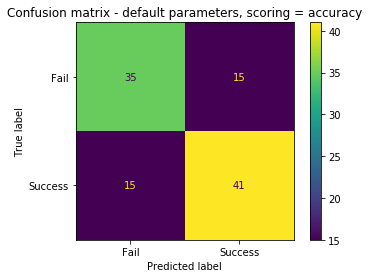

In [22]:
#Create a svm Classifier
clf_raw = SVC(kernel='linear',probability=True) # Linear Kernel

#Train the model using the training sets
clf_raw.fit(X_train_scaled, y_train)

#Predict the response for test dataset
#_raw suffix is used to identify this model in the final model reviews
y_pred_raw = clf_raw.predict(X_test_scaled)

#y_score_raw = clf_raw.predict_proba(X_test_scaled)
#retains positive values only
y_score_raw = clf_raw.predict_proba(X_test_scaled)[:,1]

#print("Accuracy =", accuracy_score(y_test, y_pred_raw))
#print("Precision =", precision_score(y_test, y_pred_raw))
#print('f1 = {:.2f}'.format(f1_score(y_test, y_pred_raw)))
#print("AUC =", roc_auc_score(y_test, y_pred_raw))

# print classification report 
print(classification_report(y_test, y_pred_raw)) 

#confusion matrix plot
disp = plot_confusion_matrix(clf_raw,X_test_scaled,y_test, display_labels=["Fail","Success"])
#set confusion matrix plot
disp.ax_.set_title('Confusion matrix - default parameters, scoring = ' + score_cat)

#print(title)
#print(disp.confusion_matrix)


<a id='section_id_algorithm_fit'></a>

### 7 Tune Hyperparameters using GridsearchCV
Use the sklearn function of GridsearchCV to find which parameters provide the best model fit when predicting the X_test_scaled dataset

Best parameters for scoring category :  accuracy
{'C': 0.05, 'kernel': 'linear'}

Classiciation Report:
               precision    recall  f1-score   support

           0       0.72      0.66      0.69        50
           1       0.72      0.77      0.74        56

    accuracy                           0.72       106
   macro avg       0.72      0.71      0.71       106
weighted avg       0.72      0.72      0.72       106



Text(0.5, 1.0, 'Confusion matrix - GridsearchCV, scoring = accuracy')

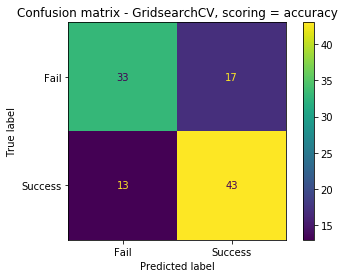

In [23]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['linear'],
#                     #'probability' : ['True'],
                     'C': [0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50]}]


#set up the Gridserch model
#cross validation fold is specified in section 2
clf_cv = GridSearchCV(SVC(probability=True, random_state= random_seed), tuned_parameters, refit = True,cv = StratifiedKFold(cross_validation_fold),scoring = score_cat) 
  
# fitting the model for grid search 
clf_cv.fit(X_train_scaled, y_train) 


#option to print out scores of cross validation fold data
#means = clf_cv.cv_results_['mean_test_score']
#stds = clf_cv.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf_cv.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r"
#          % (mean, std * 2, params)) 
 
#predictions based upon the x_test dataset using the recommended model fit    
y_pred_gridcv = clf_cv.predict(X_test_scaled) 
   
y_score_gridcv = clf_cv.predict_proba(X_test_scaled)[:,1]    
#retains positive values only
#y_score_gridcv = clf_cv.predict_proba(X_test_scaled)[:,1]
    

print("Best parameters for scoring category : ", score_cat)
print(clf_cv.best_params_) 

#display classification report
print("\nClassiciation Report:\n",classification_report(y_test, y_pred_gridcv)) 

#plot the confusion matrix - visual qc with colour fill
disp = plot_confusion_matrix(clf_cv,X_test_scaled,y_test, display_labels=["Fail","Success"])
#set confusion matrix plot
disp.ax_.set_title('Confusion matrix - GridsearchCV, scoring = ' + score_cat)


<a id='section_id_rfe'></a>

### 8 Feature section using recursive feature elimination
Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. this routine uses the best parameter outputs of gridsearchCV and outputs a mask/filter so that the optimal features can be selected in the next section. 
Cross validation fold is selected in module , as is the plot label.

The optimal number of features is 4
Ranking of features : 1


Text(0.5, 1.0, 'Support Vector Machine - Feature Selection')

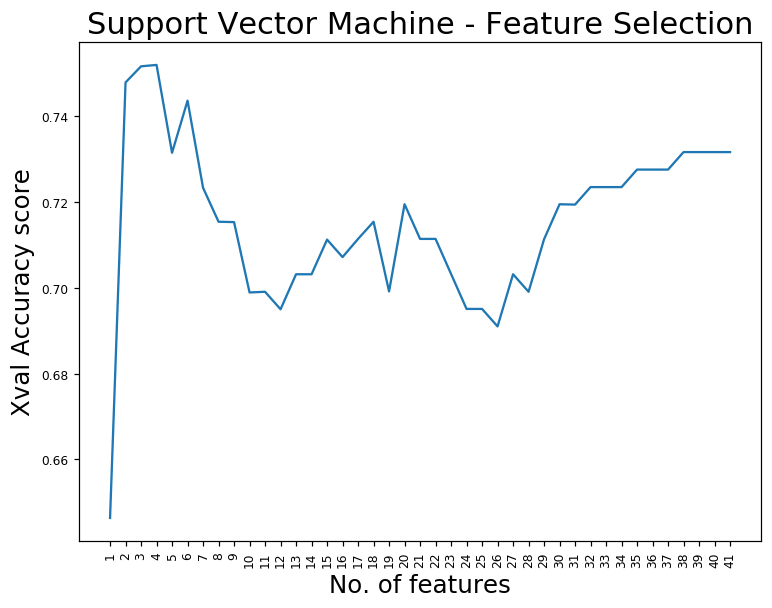

In [24]:
#Create a svm Classifier based upon the best Gridsearch parameters
clf_rfe = SVC(**clf_cv.best_params_, random_state= random_seed,probability = True) # Linear Kernel

       
# The "accuracy" scoring is proportional to the number of correct
# classifications
#rfecv = RFECV(estimator=clf_rfe,min_features_to_select=9, step=1,cv = StratifiedKFold(3),scoring=score_cat)
rfecv = RFECV(estimator=clf_rfe, step=1,cv = StratifiedKFold(cross_validation_fold),scoring=score_cat)
rfecv.fit(X_train_scaled, y_train)

print('The optimal number of features is {}'.format(rfecv.n_features_))


#print("Optimal number of features : %d" % rfecv.n_features_)
print("Ranking of features : %d" % rfecv.ranking_[0])

#plot the results of recursive feature elimination
fig_abs_var = plt.figure(num=None, figsize=(8, 6), dpi=110, facecolor='w', edgecolor='b')
fig_abs_var.canvas.set_window_title('Support Vector Machine - Optimal Number Of Features')

ax10 = fig_abs_var.add_subplot(1,1,1)
        
ax10.plot(rfecv.grid_scores_, label='grid scores - accuracy')        

labels = [item.get_text() for item in ax10.get_xticklabels()]
labels = range(1, len(rfecv.grid_scores_) + 1)
    
ax10.set_xticks(range(0,len(col_vals)))
ax10.set_xticklabels(labels,rotation=90)
ax10.tick_params(axis='both', which='major', labelsize=8)
ax10.set_xlabel('No. of features',fontsize=16)
ax10.set_ylabel('Xval ' + plot_label + ' score',fontsize=16)
ax10.set_title('Support Vector Machine - Feature Selection',fontsize=20)

<a id='section_id_filter_features'></a>

### 9 Filter training dataset to optimal number of features
Filter the input sca;ed training dataset based upon the the rfecv mask created in step 8.

In [25]:
selected_features_mask = []

for item in rfecv.support_:
   selected_features_mask.append(format(item)) 

#print(mask)

selected_features = []

print("Optimal feature selection:")
for bool, feature in zip(selected_features_mask, col_vals):
    #print(bool)
    if bool == 'True':
        print(feature)
        selected_features.append(feature[0])
 


#use the boolean mask of .support_ to filter columns based upon the RFE results
#only columns which are within the selected useful features are retained
X_train_scaled_opt = X_train_scaled[:, rfecv.support_]        
X_test_scaled_opt = X_test_scaled[:, rfecv.support_]


Optimal feature selection:
['Pg']
['Anomalies outside closure']
['Downdip conformance']
['Frequency/Character change']


<a id='section_id_final_model'></a>

### 10 Filter training dataset to optimal number of features
Fit the final gridsearchcv output model to the training dataset ehich has been  filtered to the optimal number of features.


Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.64      0.68        50
           1       0.71      0.79      0.75        56

    accuracy                           0.72       106
   macro avg       0.72      0.71      0.71       106
weighted avg       0.72      0.72      0.72       106



Text(0.5, 1.0, 'Confusion matrix - rfe parameters, scoring = accuracy')

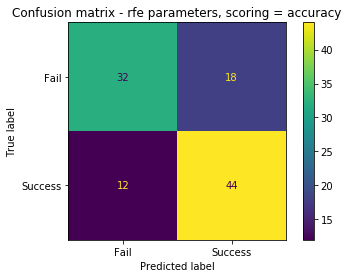

In [26]:
#Create a svm Classifier
#cannot use default gridsearchcv parameters with probability = True
clf_feature_selection = SVC(kernel='linear',probability=True,C=clf_cv.best_estimator_.get_params()['C']) # Linear Kernel
#,
#,probability=True
#Train the model using the training sets
clf_feature_selection.fit(X_train_scaled_opt, y_train)

#tuned_model = linear_model.LogisticRegression(**clf_gridcv.best_params_)    


#score = 'roc_auc'
#clf_feature_selection = GridSearchCV(SVC(), tuned_parameters, refit = True, cv = StratifiedKFold(3), scoring = score) 
  
# fitting the model for grid search 
#clf_feature_selection.fit(X_train_scaled_opt, y_train) 

# print best parameter after tuning 
#print("\nBest parameters set found on training set for score ", score, ":")
#print()
#print(clf_feature_selection.best_params_)
    
#option to print out scores of cross validation fold data
#means = clf_cv.cv_results_['mean_test_score']
#stds = clf_cv.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf_cv.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r"
#          % (mean, std * 2, params)) 
        
y_pred_rfe = clf_feature_selection.predict(X_test_scaled_opt) 
    
#y_score_rfe = clf_feature_selection.predict_proba(X_test_scaled_opt)
#retains positive values only
y_score_rfe = clf_feature_selection.predict_proba(X_test_scaled_opt)[:,1]

#print("Final, optimised best parameters:")
#print(clf_cv.best_params_) 

print("\nClassification Report:\n",classification_report(y_test, y_pred_rfe)) 
 
#confusion matrix plot   
disp = plot_confusion_matrix(clf_feature_selection,X_test_scaled_opt,y_test, display_labels=["Fail","Success"])

#set confusion matrix plot
disp.ax_.set_title('Confusion matrix - rfe parameters, scoring = ' + score_cat)

<a id='section_id_chi2_calc'></a>

### 11 Calculate Chi2 statistics for each input feature
User selected confidence interval = suggested 95%. New X training and text dataset created - contains only statistically significant events.

In [27]:
#calculate degrees freedom
#print("Unique", len(np.unique(y)))
deg_f = len(np.unique(y))-1

#critical value for passing statistical significance threshold at chosen confidence interval
critical_value = scipy.stats.chi2.ppf(conf_int, deg_f)


#find critical value for based upon stated confidence interval and number of features in output column.
print("Critical Value for Confidence Interval", conf_int, "=", critical_value,"\n")

# Select two features with highest chi-squared statistics
chi2_selector = SelectKBest(chi2, k=X.shape[1]).fit(X, y)
#chi2_selector.fit(X, y)

# Look at scores returned from the selector for each feature
df_scores = pd.DataFrame(list(zip(X.columns.tolist(), chi2_selector.scores_, chi2_selector.pvalues_)), columns=['ftr', 'score', 'pval'])

df_scores['critical_val_mask'] = df_scores['score'].map(lambda x: x>= critical_value)

chi2_mask = df_scores['critical_val_mask'].tolist()


X_train_scaled_chi2 = X_train_scaled[:, chi2_mask] 
X_test_scaled_chi2 = X_test_scaled[:, chi2_mask] 
#print(df_scores)

Critical Value for Confidence Interval 0.95 = 3.841458820694124 



<a id='section_id_chi2_list'></a>

### 12 Print statistically significant features from Chi2 calculations
Print the data features with a score >= critical value

In [28]:
#sort features by ascending p-value
chi2_scores = df_scores.sort_values(by='pval')

chi2_scores = chi2_scores[chi2_scores['score']>=critical_value]

print(chi2_scores[['ftr','score','pval']])

#print(chi2_mask)

#print(X_train_scaled)

#X_train_scaled_chi2 = X_train[chi2_mask]
#X_test_scaled_chi2 = X_test_scaled[chi2_mask]

                                             ftr      score          pval
14                    Frequency/Character change  24.668550  6.808621e-07
11                           Downdip conformance  22.433212  2.175790e-06
3                      Anomalies outside closure   9.975282  1.586557e-03
23                     Indicators proven nearby?   7.385570  6.574923e-03
19  Similar indicators on other parts of closure   6.984123  8.223594e-03
12                           Lateral conformance   6.761428  9.314921e-03
13                                     Flat Spot   6.571076  1.036493e-02
2          Consistency within mapped target area   6.140325  1.321331e-02
28                       High Porosity Wet Sands   4.876404  2.722629e-02


<a id='section_id_chi2_fit'></a>

### 13 Fit SVM model to Chi2 selected features dataset
Model parameters are the outputs of GridsearchCV


Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.64      0.67        50
           1       0.70      0.75      0.72        56

    accuracy                           0.70       106
   macro avg       0.70      0.70      0.70       106
weighted avg       0.70      0.70      0.70       106



Text(0.5, 1.0, 'Confusion matrix - chi2 parameters, scoring = accuracy')

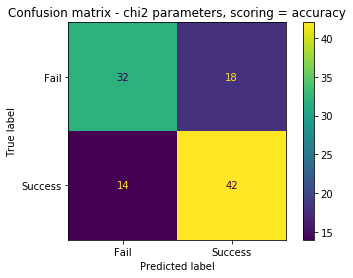

In [29]:
#Create a svm Classifier

clf_chi2_critical = SVC(kernel='linear',probability=True,C=clf_cv.best_estimator_.get_params()['C']) # Linear Kernel

clf_chi2_critical.fit(X_train_scaled_chi2, y_train)

y_pred_chi2 = clf_chi2_critical.predict(X_test_scaled_chi2) 
    
y_score_chi2 = clf_chi2_critical.predict_proba(X_test_scaled_chi2)[:,1]


print("\nClassification Report:\n",classification_report(y_test, y_pred_chi2)) 
 
#confusion matrix plot   
disp = plot_confusion_matrix(clf_chi2_critical,X_test_scaled_chi2,y_test, display_labels=["Fail","Success"])

#set confusion matrix plot
disp.ax_.set_title('Confusion matrix - chi2 parameters, scoring = ' + score_cat)

<a id='section_id_model_comparison'></a>

<a id='section_id_model_comparisons'></a>

### 14 Final model comparisons
Compare the outputs from all stages of the model evaluation: raw, gridsearchcv and rfecv.

In [30]:
def summary_scores(y_test_summary, y_pred_summary, y_score_summary):
    
    print('Accuracy score on test set: {:.2f}'.format(accuracy_score(y_test_summary, y_pred_summary)))
    print('Precision score on test set: {:.2f}'.format(precision_score(y_test_summary, y_pred_summary)))
    print('Recall score on test set: {:.2f}'.format(recall_score(y_test_summary, y_pred_summary)))
    print('Micro f1  score on test set: {:.2f}'.format(f1_score(y_test_summary, y_pred_summary, average='micro')))
    print('Macro f1  score on test set: {:.2f}'.format(f1_score(y_test_summary, y_pred_summary, average='macro')))
    print('Weighted f1  score on test set: {:.2f}'.format(f1_score(y_test_summary, y_pred_summary, average='weighted')))
    print("AUC  on test set: {:.2f}".format(roc_auc_score(y_test_summary, y_score_summary)))
    print("\n")

print("\nLinear Support Vector Machine: Default parameters\n")    
summary_scores(y_test, y_pred_raw, y_score_raw)

print("Linear Support Vector Machine: Gridsearch\n")
summary_scores(y_test, y_pred_gridcv, y_score_gridcv)

print("Linear Support Vector Machine: RFE\n")
summary_scores(y_test, y_pred_rfe, y_score_rfe)

print("Linear Support Vector Machine: Chi2 Selection\n")
summary_scores(y_test, y_pred_chi2, y_score_chi2)


Linear Support Vector Machine: Default parameters

Accuracy score on test set: 0.72
Precision score on test set: 0.73
Recall score on test set: 0.73
Micro f1  score on test set: 0.72
Macro f1  score on test set: 0.72
Weighted f1  score on test set: 0.72
AUC  on test set: 0.72


Linear Support Vector Machine: Gridsearch

Accuracy score on test set: 0.72
Precision score on test set: 0.72
Recall score on test set: 0.77
Micro f1  score on test set: 0.72
Macro f1  score on test set: 0.71
Weighted f1  score on test set: 0.72
AUC  on test set: 0.76


Linear Support Vector Machine: RFE

Accuracy score on test set: 0.72
Precision score on test set: 0.71
Recall score on test set: 0.79
Micro f1  score on test set: 0.72
Macro f1  score on test set: 0.71
Weighted f1  score on test set: 0.72
AUC  on test set: 0.77


Linear Support Vector Machine: Chi2 Selection

Accuracy score on test set: 0.70
Precision score on test set: 0.70
Recall score on test set: 0.75
Micro f1  score on test set: 0.70
Macro 

<a id='section_id_roc_curve'></a>

### 15 Receiver Operating Character (ROC) curve
Compare the roc curves for the raw, gridsearchcv, rfe and chi2 models. Labels show the AUC score.

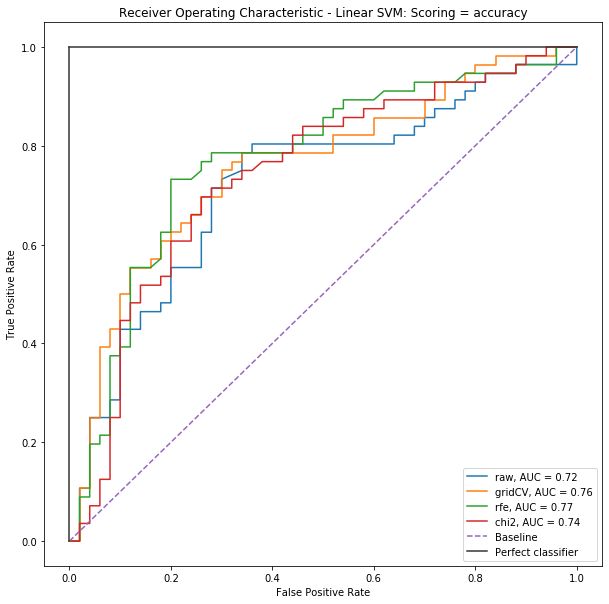

In [31]:
#ROC AUC Curve Generation for final optimised model
false_positive_raw, true_positive_raw, threshold_raw = roc_curve(y_test, y_score_raw)

#ROC AUC Curve Generation for final optimised model
false_positive_gridcv, true_positive_gridcv, threshold_tuned_feature = roc_curve(y_test, y_score_gridcv)

#ROC AUC Curve Generation for final optimised model
false_positive_rfe, true_positive_rfe, threshold_rfe = roc_curve(y_test, y_score_rfe)

#ROC AUC Curve Generation for final optimised model
false_positive_chi2, true_positive_chi2, threshold_chi2 = roc_curve(y_test, y_score_chi2)

raw_auc_label = "raw, AUC = {:.2f}".format(roc_auc_score(y_test, y_score_raw))
gridcv_auc_label = "gridCV, AUC = {:.2f}".format(roc_auc_score(y_test, y_score_gridcv))
rfe_auc_label = "rfe, AUC = {:.2f}".format(roc_auc_score(y_test, y_score_rfe))
chi2_auc_label = "chi2, AUC = {:.2f}".format(roc_auc_score(y_test, y_score_chi2))

#Plot ROC Curve
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Linear SVM: Scoring = ' + score_cat)
plt.plot(false_positive_raw, true_positive_raw, label=raw_auc_label)
plt.plot(false_positive_gridcv, true_positive_gridcv, label=gridcv_auc_label)
plt.plot(false_positive_rfe, true_positive_rfe,label=rfe_auc_label)
plt.plot(false_positive_chi2, true_positive_chi2,label=chi2_auc_label)
plt.plot([0, 1], ls="--", label='Baseline')
plt.plot([0, 0], [1, 0] , c=".2"), plt.plot([1, 1] , c=".2",label="Perfect classifier")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

#print('roc_auc_score for Linear SVM: ', roc_auc_score(y_test, y_score_tuned_feature))

<a id='section_id_pr_curve'></a>

### 16 Precision Recall (PR) curve
Compare the precision recall curves for the raw, gridsearchcv, rfe and chi2 models. Labels show the AUPR score.

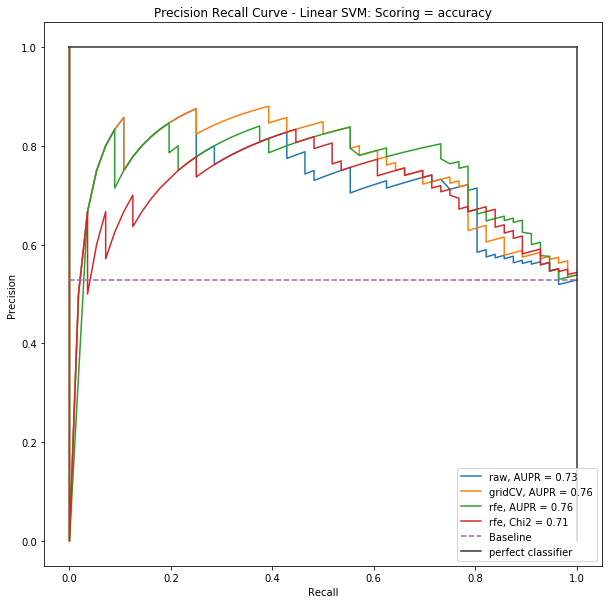

In [32]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


#AUPR Curve Generation for raw model
prec_raw, recall_raw, threshold_pr_raw = precision_recall_curve(y_test, y_score_raw)

#AUPR Curve Generation for gridsearch cv model
prec_gridcv, recall_gridcv, threshold_pr_tuned_feature = precision_recall_curve(y_test, y_score_gridcv)

#AUPR Curve Generation for final optimised model
prec_rfe, recall_rfe, threshold_pr_rfe = precision_recall_curve(y_test, y_score_rfe)

#AUPR Curve Generation for final optimised model
prec_chi2, recall_chi2, threshold_pr_chi2 = precision_recall_curve(y_test, y_score_chi2)

raw_pr_label = "raw, AUPR = {:.2f}".format(average_precision_score(y_test, y_score_raw))
gridcv_pr_label = "gridCV, AUPR = {:.2f}".format(average_precision_score(y_test, y_score_gridcv))
rfe_pr_label = "rfe, AUPR = {:.2f}".format(average_precision_score(y_test, y_score_rfe))
chi2_pr_label = "rfe, Chi2 = {:.2f}".format(average_precision_score(y_test, y_score_chi2))

baseline = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve


#Plot Precision Recall Curve
plt.subplots(1, figsize=(10,10))
plt.title('Precision Recall Curve - Linear SVM: Scoring = ' + score_cat)
plt.plot( recall_raw,prec_raw, label=raw_pr_label)
plt.plot( recall_gridcv,prec_gridcv, label=gridcv_pr_label)
plt.plot( recall_rfe,prec_rfe,label=rfe_pr_label)
plt.plot( recall_chi2,prec_chi2,label=chi2_pr_label)
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
plt.plot([0, 1], [1, 1] , c=".2"), plt.plot([1, 1] , [1, 0], c=".2",label="perfect classifier")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc="lower right")
plt.show()
